# QT Course: single-electron regime

This notebook contains exercises for the QT course on spin-qubits.

We show how to measure CSDs and provide an interactive widget.

<pieter.eendebak@tno.nl>

The model resembles the spin-qubit dot setup. The hardware consists of a virtual keithley, IVVI racks and a virtual gates object


In [1]:
# Load packages and configure simulator
#import tempfile

import numpy as np
import pyqtgraph
import qtt
import qtt.simulation.virtual_dot_array
import qtt.utilities.tools
from qcodes import find_or_create_instrument
from quantify_core.data.handling import get_datadir, set_datadir
from quantify_core.measurement import MeasurementControl
from rich import print as rprint
from qtt.utilities.tools import measure_time
from qtt.utilities.tools import profile_expression
from sqt.measurements.scan_definitions import ScanRange
from sqt.simulation.virtual_system import create_virtual_system
from sqt.utils.xarray_utils import plot_xarray_dataset as plot_dataset
import ipywidgets as widgets


station = create_virtual_system(nr_dots=4, maxelectrons=3)
station.model.sdnoise=.12
gates = station.gates
keithley1, keithley3 = station.keithley1, station.keithley3

M = np.array([[1, -0.1, -0.01], [0.1, 1, -0.1], [-0.03, -0.11, 1]])
gates.add_virtual_gate_matrix("test2", ["P1", "B1", "P2"], matrix=M)
gates.hardware.awg2dac_ratios = {gate: 80 / 1000 for gate in ["P1", "P2", "B1", "B2", "P3"]}

for ii in range(1, 17):
    p = getattr(station.ivvi1, f'dac{ii}').vals
    getattr(station.ivvi1, f'dac{ii}').vals = None
    getattr(station.ivvi2, f'dac{ii}').vals = None
    
MC = find_or_create_instrument(MeasurementControl, "MC")
MC.verbose(False)

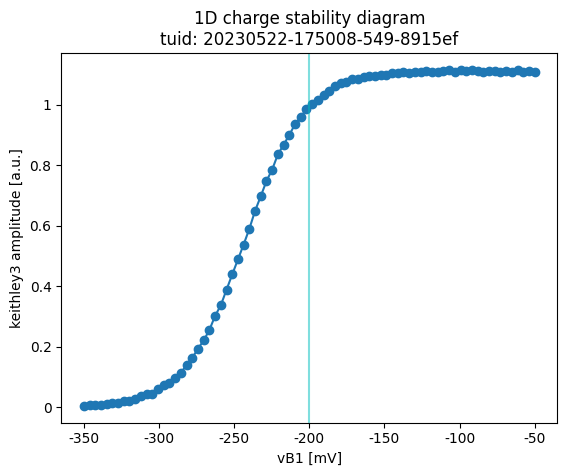

In [2]:
# %% Scan with virtual parameter

s = ScanRange(["vB1"], scanrange=300.0, number_of_points=80, centre=[-200])
s.apply(MC)

MC.gettables(keithley3.amplitude)
with gates.restore_at_exit():
    dataset = MC.run("1D charge stability diagram", save_data=False)
plot_dataset(dataset, fig=1)
s.draw_crosshair()

In [12]:
gates.P1(-350)
gates.P3(-320)

dt:  2.027 [s]


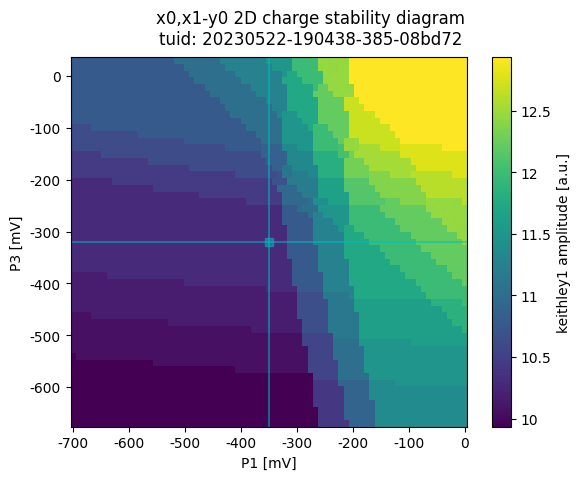

In [19]:
with measure_time():
 with gates.restore_at_exit():
    s = ScanRange.around_current(
        [gates.P1, gates.P3],
        scanrange=[700, 700],
        number_of_points=[77, 55]
    )
    s.apply(MC)

    MC.gettables(keithley1.amplitude)
    dataset = MC.run("2D charge stability diagram", save_data=False)

plot_dataset(dataset, fig=1)
s.draw_crosshair()

dt:  2.146 [s]


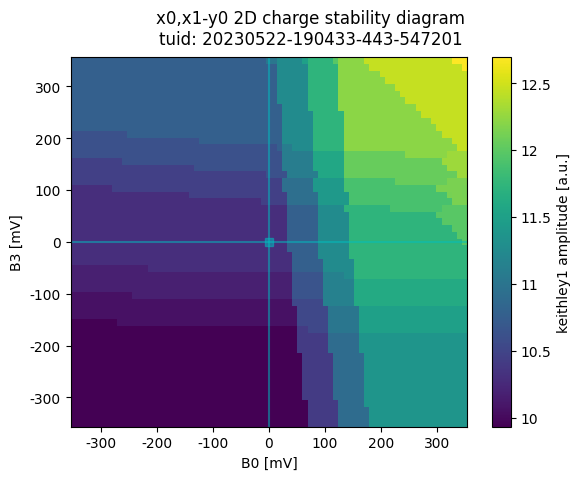

In [18]:
with measure_time():
 with gates.restore_at_exit():
    s = ScanRange.around_current(
        [gates.B0, gates.B3],
        scanrange=[700, 700],
        number_of_points=[77, 55],
    )
    s.apply(MC)

    MC.gettables(keithley1.amplitude)
    dataset = MC.run("2D charge stability diagram", save_data=False)

plot_dataset(dataset, fig=1)
s.draw_crosshair()

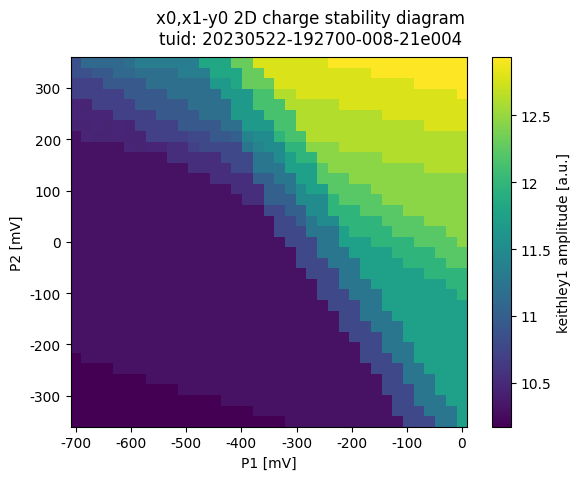

In [42]:
import ipywidgets as widgets
from quantify_core.data.handling import to_gridded_dataset
import matplotlib.pyplot as plt

with gates.restore_at_exit():
        s = ScanRange.around_current(
            [gates.P1, gates.P2],
            scanrange=[700, 700],
            number_of_points=[37, 35],
        )
        s.apply(MC)
    
        MC.gettables(keithley1.amplitude)
        dataset = MC.run("2D charge stability diagram", save_data=False)
        g=to_gridded_dataset(dataset)
plot_dataset(dataset, fig=1)
g=to_gridded_dataset(dataset)

ax=plt.gca()
#Fig.axes
#plt.clf()
g.y0.transpose().plot(ax=ax, add_colorbar=False);

In [92]:
import matplotlib.pyplot as plt
slider_gates=['P1', 'P2', 'P3', 'P4']
sliders = {key: widgets.FloatSlider(value=gates.get(key), min=-800, max=500, description=f'{key} [mV]', continuous_update=False) for ii,key in enumerate(slider_gates)  }
sliders['nx']=widgets.IntSlider(value=60, min=10, max=160, description='nx', continuous_update=False)
sliders['ny']=widgets.IntSlider(value=60, min=10, max=100, description='ny', continuous_update=False)

sliders['range_x']=widgets.IntSlider(value=500, min=.1, max=800, description='Range x [mV]', continuous_update=False)
sliders['range_y']=widgets.IntSlider(value=500, min=.1, max=800, description='Range y [mV]', continuous_update=False)

print(sliders)

{'P1': FloatSlider(value=-350.0, continuous_update=False, description='P1 [mV]', max=500.0, min=-800.0), 'P2': FloatSlider(value=-0.17712603278891859, continuous_update=False, description='P2 [mV]', max=500.0, min=-800.0), 'P3': FloatSlider(value=-320.0, continuous_update=False, description='P3 [mV]', max=500.0, min=-800.0), 'P4': FloatSlider(value=-0.46031048912713846, continuous_update=False, description='P4 [mV]', max=500.0, min=-800.0), 'nx': IntSlider(value=60, continuous_update=False, description='nx', max=160, min=10), 'ny': IntSlider(value=60, continuous_update=False, description='ny', min=10), 'range_x': IntSlider(value=500, continuous_update=False, description='Range x [mV]', max=800), 'range_y': IntSlider(value=500, continuous_update=False, description='Range y [mV]', max=800)}


In [95]:
s.draw_crosshair?

Signature: s.draw_crosshair(ax: Optional[Any] = None, **kwargs)
Docstring: <no docstring>
File:      c:\projects\sqt\src\sqt\measurements\scan_definitions.py
Type:      method


In [97]:
from ipywidgets import interact, interactive, fixed, interact_manual
#station.model.sdnoise=.12


layout=layout = widgets.Layout(grid_template_columns='1fr 1fr 1fr')
ui = widgets.GridBox(list(sliders.values()), layout=layout)

#plot_dataset(dataset, fig=1)
#ax=plt.gca()
def f(*args,  verbose=0, **kwargs):
    if verbose:
        print('interactive method: ', args, kwargs)

    nx,ny=kwargs.get('nx',50), kwargs.get('ny', 50)
    scanrange=kwargs.get('range_x',500), kwargs.get('range_y', 500)
    with measure_time(message='calculation time:') as dt:
      with gates.restore_at_exit():
        for g, v in kwargs.items():      
            if g in gates.parameters:
              gates.set(g, v)
              if verbose>=2:
                  print(f'set {g} to {v}')
        s = ScanRange.around_current(
            [gates.P1, gates.P2],
            scanrange=scanrange,
            number_of_points=[nx, ny],
        )
        s.apply(MC)
    
        MC.gettables(keithley1.amplitude)
        dataset = MC.run("2D charge stability diagram", save_data=False)
        g=to_gridded_dataset(dataset)

    ax=plt.gca()
    #Fig.axes
    #plt.clf()
    if verbose>=2:
        print('update plot')
    g.y0.transpose().plot(ax=ax, add_colorbar=False);
    s.draw_crosshair(alpha=.2)
    #print(g.y0[0:100:20])
    #plt.draw()
    #plt.pause(1e-3)
   
#interact(f, sliders) # , continuous_update=False)

out = widgets.interactive_output(f, sliders)
display(ui, out)

GridBox(children=(FloatSlider(value=-482.3, continuous_update=False, description='P1 [mV]', max=500.0, min=-80…

Output()

In [68]:
#interact?
interactive?

Init signature: interactive(_interactive__interact_f, _interactive__options={}, **kwargs)
Docstring:     
A VBox container containing a group of interactive widgets tied to a
function.

Parameters
----------
__interact_f : function
    The function to which the interactive widgets are tied. The `**kwargs`
    should match the function signature.
__options : dict
    A dict of options. Currently, the only supported keys are
    ``"manual"`` (defaults to ``False``), ``"manual_name"`` (defaults
    to ``"Run Interact"``) and ``"auto_display"`` (defaults to ``False``).
**kwargs : various, optional
    An interactive widget is created for each keyword argument that is a
    valid widget abbreviation.

Note that the first two parameters intentionally start with a double
underscore to avoid being mixed up with keyword arguments passed by
``**kwargs``.
Init docstring: Public constructor
File:           c:\develop\env311\lib\site-packages\ipywidgets\widgets\interaction.py
Type:           MetaHa

In [73]:
from ipywidgets import interact, interactive, fixed, interact_manual

interact(f, **sliders);

interactive(children=(FloatSlider(value=-141.60000000000002, continuous_update=False, description='P1', max=50…

End of the exercises.